# Style generation with IMDb data

We are going to loosely follow the fast.ai tutorial on fine-tuning a model to classify IMDb reviews. The original code is [here](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb). Since we're just interested in fine-tuning a language model to do text generation, we're going to ignore all the stuff about classes/labels/classifiers and just focus on the language model.

In [1]:
from fastai_old.text import *
import html
import spacy 

spacy.load('en')

## Get data

We need to download the IMDB large movie reviews from this site: http://ai.stanford.edu/~amaas/data/sentiment/ Direct link : Link and untar it into the PATH location. We use pathlib which makes directory traveral a breeze.

In [19]:
DATA_PATH=Path('data/')
DATA_PATH.mkdir(exist_ok=True)
#! curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
#! tar -xzfv aclImdb_v1.tar.gz -C {DATA_PATH}

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/aclImdb/aclImdb')

The imdb dataset has 3 classes. positive, negative and unsupervised(sentiment is unknown). There are 75k training reviews(12.5k pos, 12.5k neg, 50k unsup) There are 25k validation reviews(12.5k pos, 12.5k neg & no unsup).

Refer to the README file in the imdb corpus for further information about the dataset.

Since we are just interested in the language model, we're going to ignore all the information about the classes/labels. And since there is so much data -- we don't want to use it all -- we are just going to look at the unsupervised reviews, where the sentiment is unknown.

In [20]:
# CLAS_PATH=Path('data/imdb_clas/')
# CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

In [21]:
ls data/imdb_lm/

We're also going to decrease the amount of data to less than 10k examples. This will speed things up and make it closer to the typical small datasets we're interested in.

In [25]:
CLASSES = ['unsup']
maxn = 8000

def get_texts(path):
    texts = []
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            if len(texts) >= maxn:
                break
            texts.append(fname.open('r', encoding='utf-8').read())
    return np.array(texts)

all_texts = get_texts(PATH/'train')
len(all_texts)

8000

In [26]:
all_texts[0]

'This is just a precious little diamond. The play, the script are excellent. I cant compare this movie with anything else, maybe except the movie "Leon" wonderfully played by Jean Reno and Natalie Portman. But... What can I say about this one? This is the best movie Anne Parillaud has ever played in (See please "Frankie Starlight", she\'s speaking English there) to see what I mean. The story of young punk girl Nikita, taken into the depraved world of the secret government forces has been exceptionally over used by Americans. Never mind the "Point of no return" and especially the "La femme Nikita" TV series. They cannot compare the original believe me! Trash these videos. Buy this one, do not rent it, BUY it. BTW beware of the subtitles of the LA company which "translate" the US release. What a disgrace! If you cant understand French, get a dubbed version. But you\'ll regret later :)'

Let's split it into 90% train and 10% validation sets. This function is probably overkill, and makes the code unnecessarily complicated and reliant on external libraries, but whatever. Maybe I'll clean it up later.

In [27]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    all_texts, test_size=0.1)

len(trn_texts), len(val_texts)

(7200, 800)

## Preprocess data

We're going to follow this pandas dataframe format because that's what the fast.ai tutorial uses and also because I think it makes the pre-processing go faster.

They say: "The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns. This was influenced by a paper by Yann LeCun (LINK REQUIRED). Fastai adopts this new format for NLP datasets. In the case of IMDB, there is only one text column."

In [28]:
col_names = ['text']
df_trn = pd.DataFrame({'text':trn_texts}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts}, columns=col_names)

df_trn['text'][0]

'Tommy is taken from his family by an Amazon tribe called "The Invisible Ones" and father Bill spends ten years searching for him. After finding a few leads, he has an encounter with a dangerous cannibal tribe called "The Fierce Ones" and actually stumbles on his son as he tries to flee for his life. The dilemma of the piece comes with a decision left up to Tommy, leave his tribe which are essentially his real family after ten years of living with them or joining his father in the modern civilization across the river.<br /><br />The film is more a focus on how modernization, progress if you will, has began to wipe out the trees and land of Amazon tribes as they slowly die out. Interesting enough is that Bill is a model example of this type of progress as he heads a log dam which clears land once civilized by The Fierce Ones tribe. He will spend time with The Invisible Ones tribe and find the error of his ways seeing that what he and others(White Man)are doing to people who have lived h

Now we'll create some functions that will allow us to read the data and convert it into a set of numbers, where each number represents a word. These will clean up the data.

In [29]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df):
    texts = f'\n{BOS} {FLD} 1 ' + df['text'].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok

In [30]:
tok_trn = get_texts(df_trn)
tok_val = get_texts(df_val) 

Let's save these so we can load them later and not have to do the pre-processing again:

In [32]:
np.save(LM_PATH/'tmp'/'tok_trn_style.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val_style.npy', tok_val)

In [33]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn_style.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val_style.npy')

Let's have a look at the most frequent words in this corpus.

In [34]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(15)

[('the', 98257),
 (',', 80435),
 ('.', 79034),
 ('and', 50047),
 ('a', 47147),
 ('of', 42953),
 ('to', 38092),
 ('is', 32608),
 ('in', 27909),
 ('it', 26843),
 ('i', 23120),
 ('this', 20718),
 ('that', 20327),
 ("'s", 18237),
 ('"', 18112)]

Okay here we're going to set our up string-to-integer dictionary and integer-to-string list for the vocab. We'll set a max and min frequency, which can be used to limit the vocabularly size.

In [35]:
max_vocab = 60000
min_freq = 2

In [36]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [37]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

20915

Now we're going to create these language model objects, which is a list of imbd reviews where each imdb review is a list of integers -- the words in the review (in order).

In [38]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

#### TODO: save all this, pickle itos, stoi, etc. 

In [39]:
vs=len(itos)
vs,len(trn_lm)

(20915, 7200)

## Set up pretrained model

We are going to first load a pre-trained language model. Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/).
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the style LM. 

In [41]:
#! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target IMDB LM so that the weights can be loaded up.

Note that the 'models' directory should be in 'aclimbd'.

In [42]:
em_sz,nh,nl = 400,1150,3

PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

Then we load the itos and stoi for the pre-trained language model.

In [43]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

len(itos2)

238462

Not sure what happens to these words that are in the imbd reviews but *not* in the pre-trained model...

In [44]:
oov = set(itos) - set(itos2).intersection(itos)
len(oov), list(oov)[0:10]

(813,
 ['faute',
  ':)',
  "i'd",
  'wryn',
  'nastassja',
  'hessling',
  'teamings',
  'frights',
  ';)',
  'infact'])

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [45]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):                     # for word in imbd vocab
    r = stoi2[w]                                # get the int in the pretrained vocab
    new_w[i] = enc_wgts[r] if r>=0 else row_m   # add weight if in vocab, else add mean weight

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [46]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [47]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [48]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [49]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [50]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.model.load_state_dict(wgts)

In [54]:
def generate_text(m, s, l=20):
    m[0].bs=1  # Set batch size to 1
    m.eval()  # Turn off dropout
    m.reset()  # Reset hidden state
    m[0].bs=bs  # Put the batch size back to what it was

    ss = s.lower().split()
    si = [stoi[w] for w in ss]
    t = torch.autograd.Variable(torch.cuda.LongTensor(np.array([si])))
    
    res,*_ = m(t)

    print(s,"\n")
    for i in range(l):
        n = res[-1].topk(2)[1]
        n = n[1] if n.data[0]==0 else n[0]
        print(itos[n], end=' ')
        res,*_ = m(n.unsqueeze(0).unsqueeze(0))
    print('...')

In [55]:
m=learner.model

In [56]:
generate_text(m, "The movie was")

The movie was 

not only the first of the two , but also the first to be named after the first person . ...


## Training!

Alright, let's do some training and see how it changes the language model...

In [59]:
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [60]:
lr=1e-3
lrs = lr

In [61]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      4.897061   4.623872   0.242906  



[4.623871652285258, 0.24290621976057689]

In [62]:
itos_imdb = itos
with open(PRE_PATH/'itos_imdb.pkl', 'wb') as f:
    pickle.dump(itos_imdb, f)
learner.save('lm_last_ft')

In [63]:
learner.load('lm_last_ft')

In [64]:
m=learner.model

In [65]:
generate_text(m, "The movie was", l=50)

The movie was 

a few days later , the first of the three , the " great " , was released . the first of these was the " the great " , which was released on the same day as the second . the second was the " the great " , ...


More training!

In [66]:
learner.unfreeze()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      4.719828   4.530629   0.23558   



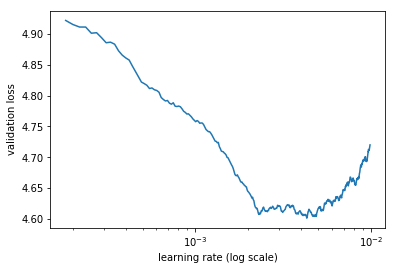

In [67]:
learner.sched.plot()

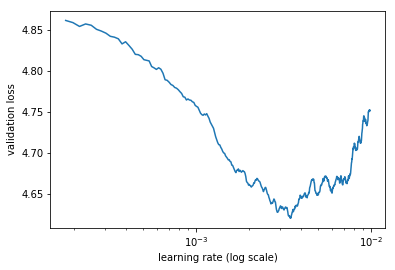

In [118]:
learner.sched.plot()

In [68]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=3)

epoch      trn_loss   val_loss   accuracy                   
    0      4.463104   4.182683   0.271784  
    1      4.232727   4.104237   0.278672                   
    2      4.117621   4.080595   0.281202                   



[4.080595497290293, 0.2812017594774564]

In [69]:
learner.save('lm_3epochs')
m=learner.model
generate_text(m, "The movie was", l=50)

The movie was 

a few years later , the film is a bit too long and has a lot of fun . 

 the film is a bit of a comedy , but it 's a very good film . it 's a very good film , and it 's a good film ...
